# MLP
MLP, K=5, droput, 150 epoch.

mRNA. Baseline. No exclusions. 

Like MLP_264 but use class weights.

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-13 12:52:28.849078


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_263'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.pc_RCI.csv'
RCI_FILE_TEST  = None #'test.pc_RCI.csv'

SEQ_FILE_TRAIN = 'train.all_pc_transcripts.csv'
SEQ_FILE_TEST  = None #'test.all_pc_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-13 12:53:05.023946
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = 0 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = 0   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd)  # no validation 
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) )   

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold) # lncRNA
        filename='pc.{}.{}.validation_genes.txt'.format(rep,fold) # mRNA
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            # use -2 and 0 for lncRNA, use -1 and +1 for mRNA
            in_middle = gene_to_rci[gene_id] >= -1 and gene_to_rci[gene_id] <= 1
            in_tails = gene_to_rci[gene_id] < -1 or gene_to_rci[gene_id] > 1
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-13 12:53:05.357848
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.pc_RCI.csv
Number of RCI values loaded 13662
Num RCI: 13662
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.all_pc_transcripts.csv
Loaded 131211 sequences.

Training # 1 1
2023-04-13 12:57:54.644424
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.1.validation_genes.txt
2023-04-13 12:57:56.328435
Discriminator ZERO 0
Train 1:0 42680:61663 40.90%
Computed class weights: {0: 0.8460746314645736, 1: 1.222387535145267}
Valid 1:0 10560:16308 39.30%
FIT
2023-04-13 12:57:57.254380


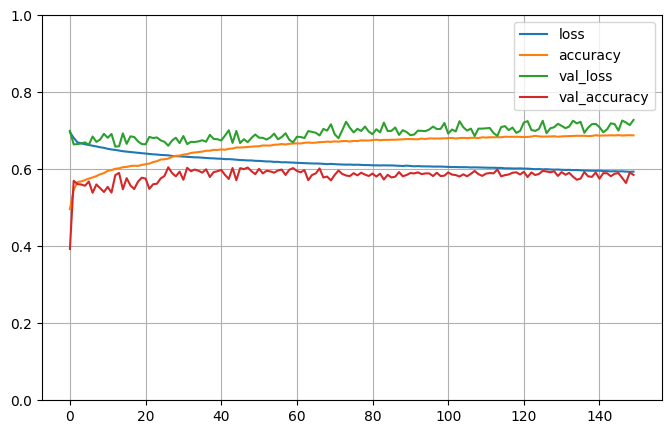


Testing # 1 1
2023-04-13 13:44:21.437299
2023-04-13 13:44:21.437420
PREDICT
2023-04-13 13:44:21.656742
Test 1:0 10560:16308 39.30%
Predict 1:0 10475:16393 38.99%
Test sizes (26868, 1025) (26868,)
Distrib of scores: 0.48306975 mean 0.2156904 std
Range of scores: 0.022215022 to 0.9687287
Score threshold 0.5
Confusion matrix
 [[10778  5530]
 [ 5615  4945]]
Normalized matrix
 [[0.40114635 0.20582105]
 [0.20898467 0.18404794]]
Extreme scores correct, pos:neg 3282 4093
Extreme scores incorrect pos:neg 3391 1415


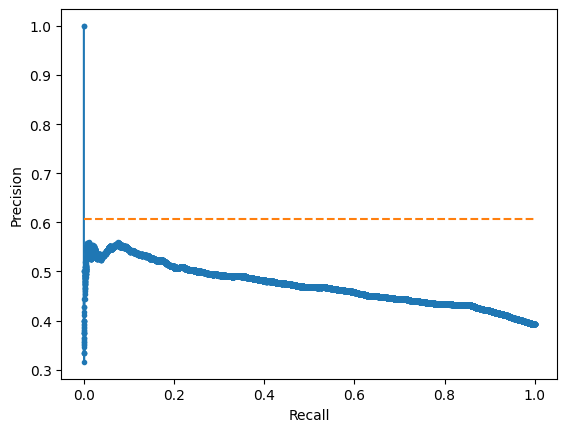

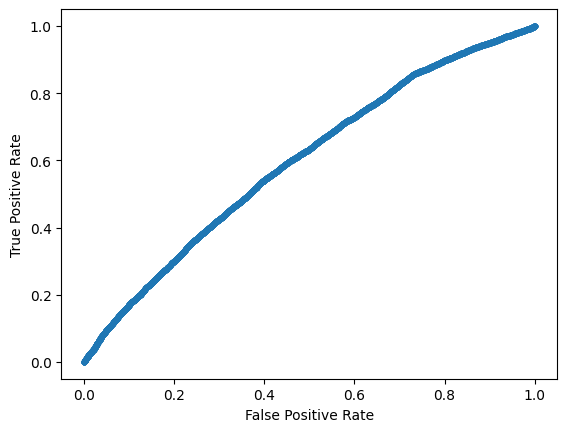

Accuracy: 58.52% Precision: 47.21% Recall: 46.83%
F1: 47.02% MCC: 0.1294
AUPRC: 47.18% AUROC: 59.78%
 accuracy [58.5194283162126]
 precision [47.20763723150358]
 recall [46.827651515151516]
 F1 [47.01687663418112]
 MCC [0.12936549747250917]
 AUPRC [47.18134460710571]
 AUROC [59.78276167906067]

Training # 1 2
2023-04-13 13:44:24.412055
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.2.validation_genes.txt
2023-04-13 13:44:25.401353
Discriminator ZERO 0
Train 1:0 42176:62771 40.19%
Computed class weights: {0: 0.8359513150977362, 1: 1.2441554438543247}
Valid 1:0 11064:15200 42.13%
FIT
2023-04-13 13:44:26.330676


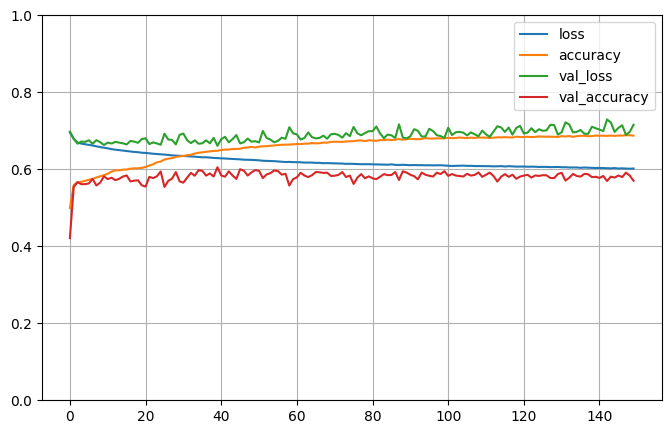


Testing # 1 2
2023-04-13 14:31:21.696120
2023-04-13 14:31:21.696547
PREDICT
2023-04-13 14:31:21.860092
Test 1:0 11064:15200 42.13%
Predict 1:0 11598:14666 44.16%
Test sizes (26264, 1025) (26264,)
Distrib of scores: 0.51413757 mean 0.19428986 std
Range of scores: 0.045259424 to 0.93411463
Score threshold 0.5
Confusion matrix
 [[9289 5911]
 [5377 5687]]
Normalized matrix
 [[0.35367804 0.22506092]
 [0.20472891 0.21653214]]
Extreme scores correct, pos:neg 4036 3056
Extreme scores incorrect pos:neg 3682 1047


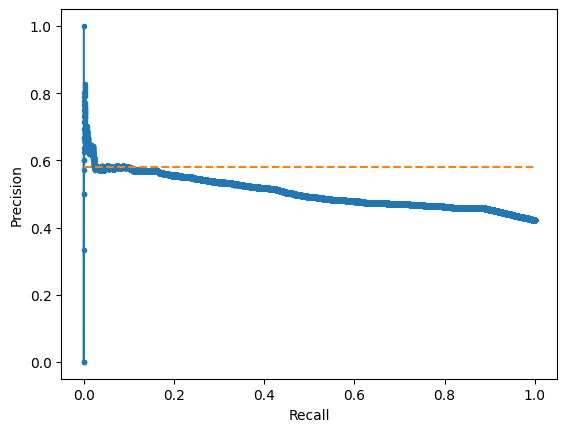

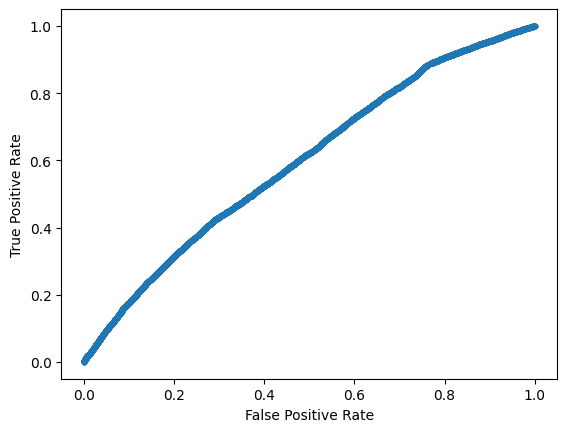

Accuracy: 57.02% Precision: 49.03% Recall: 51.40%
F1: 50.19% MCC: 0.1244
AUPRC: 50.56% AUROC: 59.83%
 accuracy [57.02101736216875]
 precision [49.03431626142438]
 recall [51.400939985538685]
 F1 [50.18974494748918]
 MCC [0.12441832961774733]
 AUPRC [50.556219722273866]
 AUROC [59.82624657495148]

Training # 1 3
2023-04-13 14:31:25.782754
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.3.validation_genes.txt
2023-04-13 14:31:26.922108
Discriminator ZERO 0
Train 1:0 42890:62917 40.54%
Computed class weights: {0: 0.840845876313238, 1: 1.2334693401725343}
Valid 1:0 10350:15054 40.74%
FIT
2023-04-13 14:31:27.768793


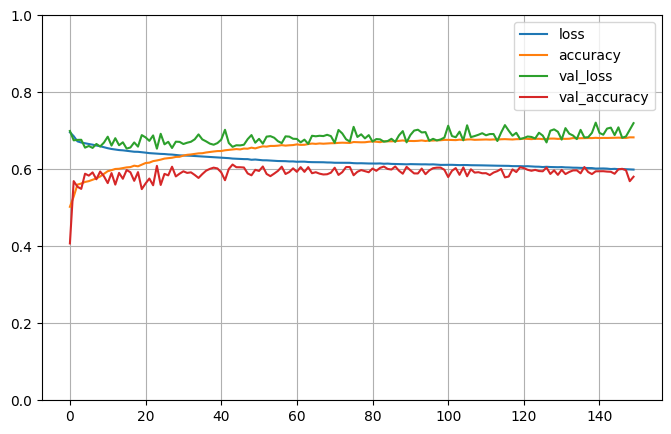


Testing # 1 3
2023-04-13 15:19:52.897552
2023-04-13 15:19:52.897616
PREDICT
2023-04-13 15:19:53.090798
Test 1:0 10350:15054 40.74%
Predict 1:0 11829:13575 46.56%
Test sizes (25404, 1025) (25404,)
Distrib of scores: 0.5169073 mean 0.20839566 std
Range of scores: 0.011662478 to 0.9742543
Score threshold 0.5
Confusion matrix
 [[8988 6066]
 [4587 5763]]
Normalized matrix
 [[0.35380255 0.23878129]
 [0.18056212 0.22685404]]
Extreme scores correct, pos:neg 3865 3128
Extreme scores incorrect pos:neg 3548 924


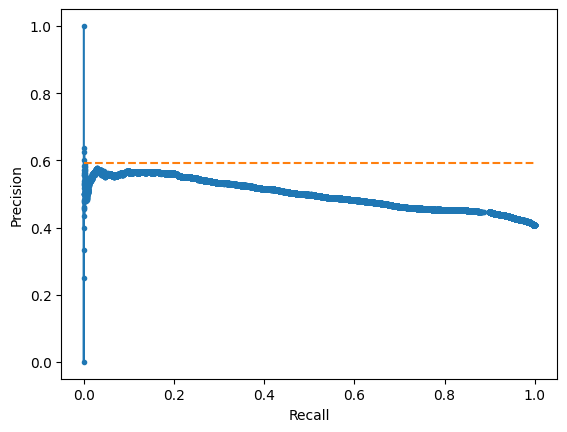

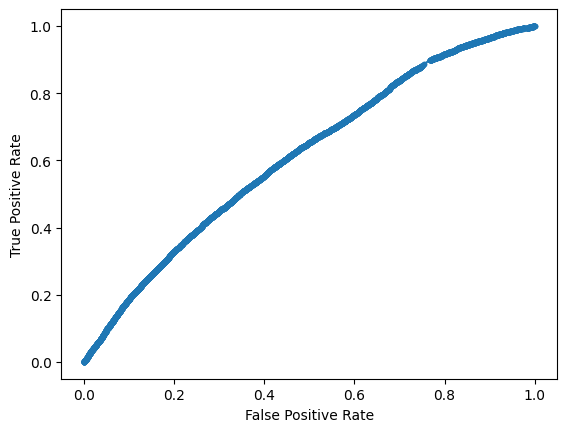

Accuracy: 58.07% Precision: 48.72% Recall: 55.68%
F1: 51.97% MCC: 0.1516
AUPRC: 49.90% AUROC: 61.32%
 accuracy [58.065658951346244]
 precision [48.7192493025615]
 recall [55.68115942028985]
 F1 [51.96807791153793]
 MCC [0.1515598502309217]
 AUPRC [49.90342771513365]
 AUROC [61.320587591594574]

Training # 1 4
2023-04-13 15:19:55.924272
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.4.validation_genes.txt
2023-04-13 15:19:57.103455
Discriminator ZERO 0
Train 1:0 42682:62515 40.57%
Computed class weights: {0: 0.8413740702231465, 1: 1.2323344735485684}
Valid 1:0 10558:15456 40.59%
FIT
2023-04-13 15:19:58.458338


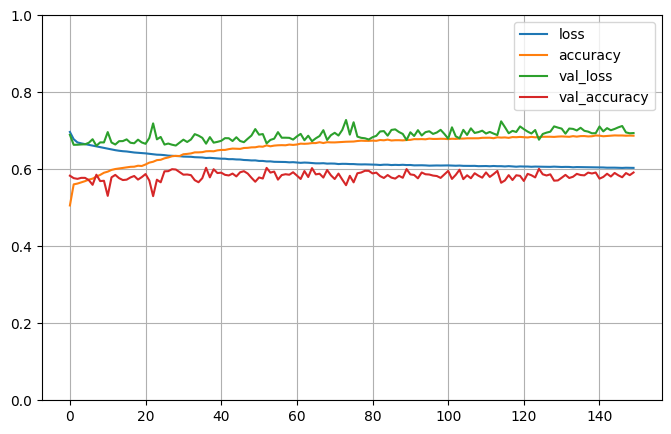


Testing # 1 4
2023-04-13 16:08:22.793038
2023-04-13 16:08:22.793271
PREDICT
2023-04-13 16:08:23.030234
Test 1:0 10558:15456 40.59%
Predict 1:0 9178:16836 35.28%
Test sizes (26014, 1025) (26014,)
Distrib of scores: 0.46616057 mean 0.19474132 std
Range of scores: 0.050596647 to 0.8750023
Score threshold 0.5
Confusion matrix
 [[10835  4621]
 [ 6001  4557]]
Normalized matrix
 [[0.4165065  0.17763512]
 [0.23068348 0.17517491]]
Extreme scores correct, pos:neg 3043 4229
Extreme scores incorrect pos:neg 2693 1491


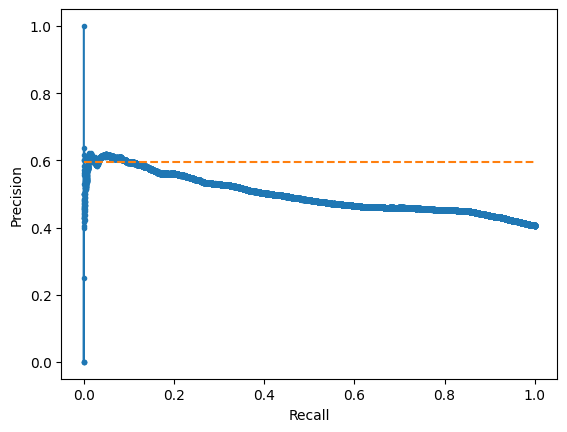

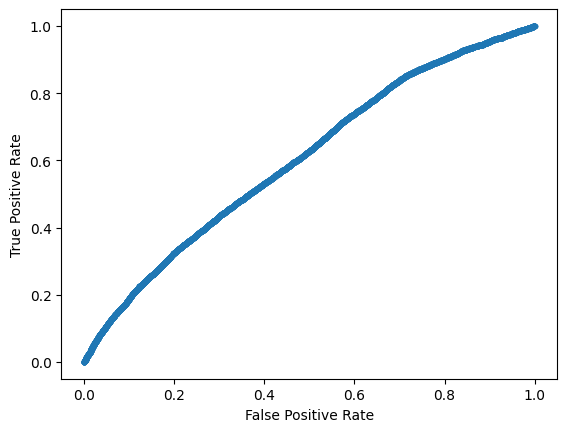

Accuracy: 59.17% Precision: 49.65% Recall: 43.16%
F1: 46.18% MCC: 0.1363
AUPRC: 49.80% AUROC: 60.47%
 accuracy [59.16814023218267]
 precision [49.65134016125518]
 recall [43.16158363326388]
 F1 [46.179570328334016]
 MCC [0.13630574711221613]
 AUPRC [49.80389217272181]
 AUROC [60.46894125597066]

Training # 1 5
2023-04-13 16:08:26.741451
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.1.5.validation_genes.txt
2023-04-13 16:08:28.494038
Discriminator ZERO 0
Train 1:0 42532:62018 40.68%
Computed class weights: {0: 0.8429004482569576, 1: 1.2290745791404118}
Valid 1:0 10708:15953 40.16%
FIT
2023-04-13 16:08:29.887686


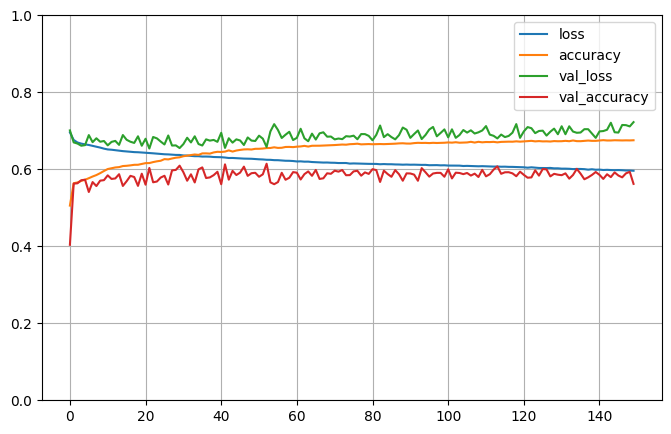


Testing # 1 5
2023-04-13 16:56:56.591918
2023-04-13 16:56:56.592409
PREDICT
2023-04-13 16:56:56.971064
Test 1:0 10708:15953 40.16%
Predict 1:0 13508:13153 50.67%
Test sizes (26661, 1025) (26661,)
Distrib of scores: 0.522401 mean 0.19116123 std
Range of scores: 0.024661697 to 0.9850241
Score threshold 0.5
Confusion matrix
 [[8715 7238]
 [4438 6270]]
Normalized matrix
 [[0.32688196 0.27148269]
 [0.16646037 0.23517497]]
Extreme scores correct, pos:neg 3680 3505
Extreme scores incorrect pos:neg 3433 1401


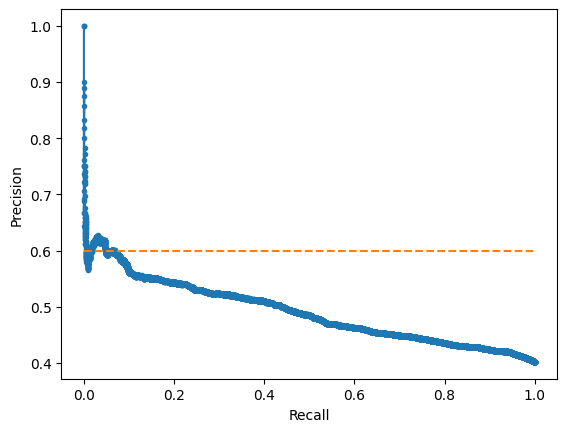

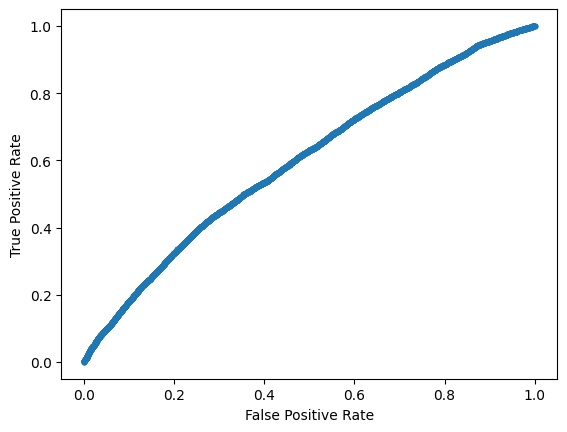

Accuracy: 56.21% Precision: 46.42% Recall: 58.55%
F1: 51.78% MCC: 0.1293
AUPRC: 49.12% AUROC: 59.89%
 accuracy [56.20569370991335]
 precision [46.416938110749186]
 recall [58.554351886440045]
 F1 [51.783944499504464]
 MCC [0.1292708574807924]
 AUPRC [49.12117948087944]
 AUROC [59.89400896090428]

Training # 2 1
2023-04-13 16:57:00.697587
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.1.validation_genes.txt
2023-04-13 16:57:01.726901
Discriminator ZERO 0
Train 1:0 42379:62864 40.27%
Computed class weights: {0: 0.8370689106642911, 1: 1.2416881002383255}
Valid 1:0 10861:15107 41.82%
FIT
2023-04-13 16:57:02.903213


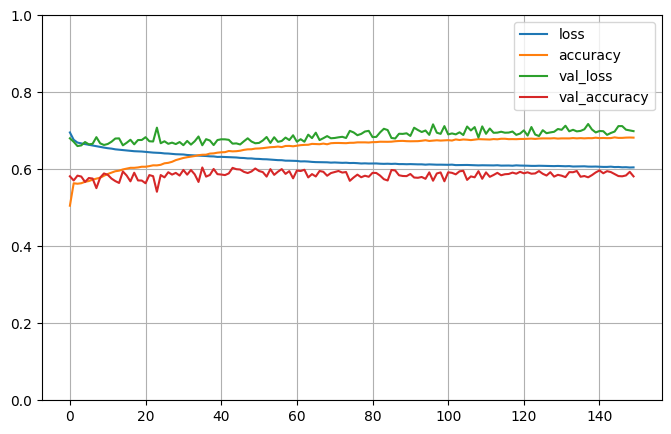


Testing # 2 1
2023-04-13 17:47:49.975733
2023-04-13 17:47:49.976318
PREDICT
2023-04-13 17:47:50.147101
Test 1:0 10861:15107 41.82%
Predict 1:0 11393:14575 43.87%
Test sizes (25968, 1025) (25968,)
Distrib of scores: 0.4938283 mean 0.183198 std
Range of scores: 0.03275877 to 0.86699134
Score threshold 0.5
Confusion matrix
 [[9408 5699]
 [5167 5694]]
Normalized matrix
 [[0.36229205 0.21946242]
 [0.19897566 0.21926987]]
Extreme scores correct, pos:neg 3806 3274
Extreme scores incorrect pos:neg 3204 1192


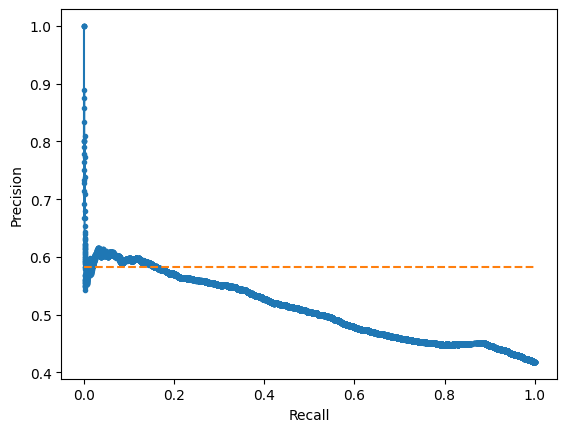

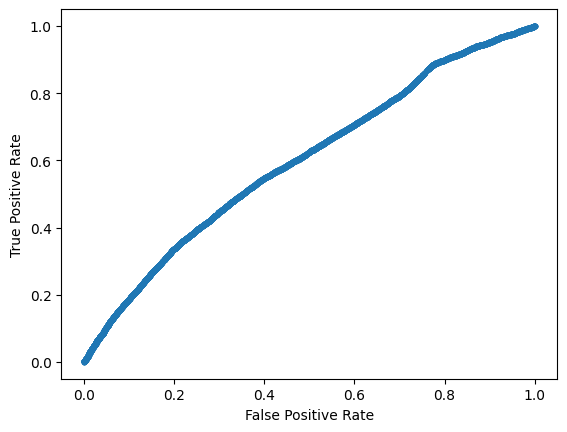

Accuracy: 58.16% Precision: 49.98% Recall: 52.43%
F1: 51.17% MCC: 0.1461
AUPRC: 50.99% AUROC: 60.01%
 accuracy [58.15619223659889]
 precision [49.97805670148337]
 recall [52.42611177607955]
 F1 [51.17282286330548]
 MCC [0.14614148124731247]
 AUPRC [50.98616099832818]
 AUROC [60.00994154413735]

Training # 2 2
2023-04-13 17:47:52.879333
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.2.validation_genes.txt
2023-04-13 17:47:53.959300
Discriminator ZERO 0
Train 1:0 42997:61797 41.03%
Computed class weights: {0: 0.8478890561030471, 1: 1.2186199037142127}
Valid 1:0 10243:16174 38.77%
FIT
2023-04-13 17:47:55.292946


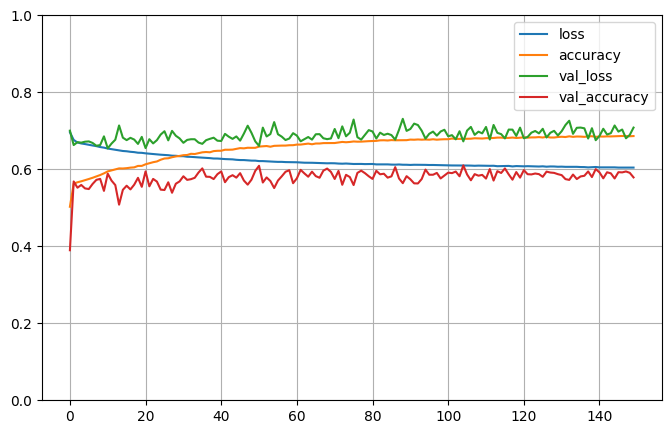


Testing # 2 2
2023-04-13 18:40:20.281211
2023-04-13 18:40:20.281261
PREDICT
2023-04-13 18:40:20.454684
Test 1:0 10243:16174 38.77%
Predict 1:0 11239:15178 42.54%
Test sizes (26417, 1025) (26417,)
Distrib of scores: 0.49551794 mean 0.19913018 std
Range of scores: 0.076561086 to 0.86351335
Score threshold 0.5
Confusion matrix
 [[10114  6060]
 [ 5064  5179]]
Normalized matrix
 [[0.38285952 0.22939774]
 [0.19169474 0.196048  ]]
Extreme scores correct, pos:neg 3616 3863
Extreme scores incorrect pos:neg 3764 1157


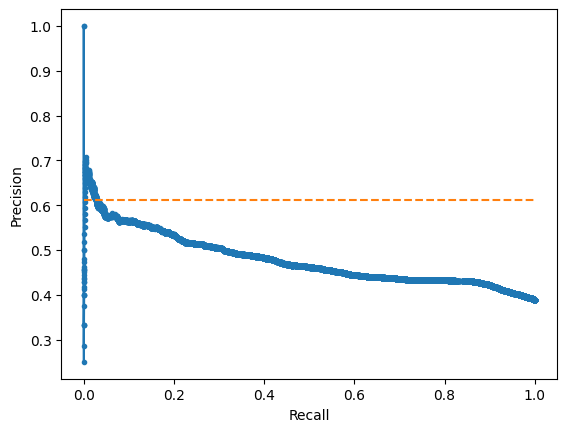

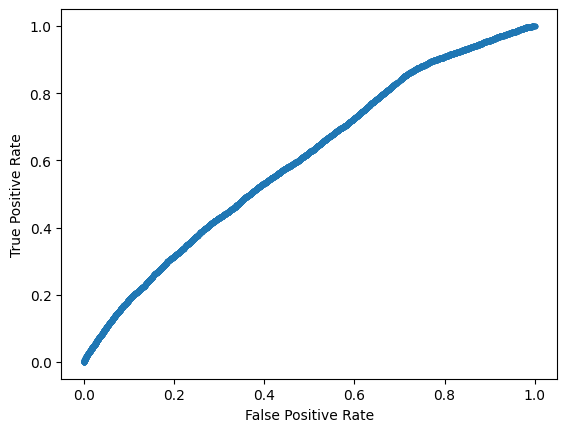

Accuracy: 57.89% Precision: 46.08% Recall: 50.56%
F1: 48.22% MCC: 0.1290
AUPRC: 47.79% AUROC: 60.26%
 accuracy [57.89075216716508]
 precision [46.080612154106234]
 recall [50.561358976862245]
 F1 [48.217112000744805]
 MCC [0.1290379669326631]
 AUPRC [47.79487487425008]
 AUROC [60.26290279387585]

Training # 2 3
2023-04-13 18:40:23.097445
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.3.validation_genes.txt
2023-04-13 18:40:24.015037
Discriminator ZERO 0
Train 1:0 42330:62726 40.29%
Computed class weights: {0: 0.837419889678921, 1: 1.2409166076068983}
Valid 1:0 10910:15245 41.71%
FIT
2023-04-13 18:40:24.880743


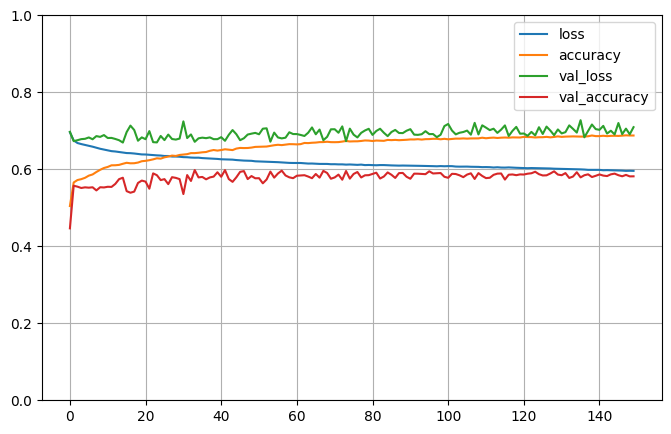


Testing # 2 3
2023-04-13 19:30:49.013076
2023-04-13 19:30:49.013133
PREDICT
2023-04-13 19:30:49.185936
Test 1:0 10910:15245 41.71%
Predict 1:0 10304:15851 39.40%
Test sizes (26155, 1025) (26155,)
Distrib of scores: 0.48698747 mean 0.1969477 std
Range of scores: 0.024823353 to 0.9897848
Score threshold 0.5
Confusion matrix
 [[10078  5167]
 [ 5773  5137]]
Normalized matrix
 [[0.38531829 0.19755305]
 [0.22072262 0.19640604]]
Extreme scores correct, pos:neg 3296 3457
Extreme scores incorrect pos:neg 2848 1281


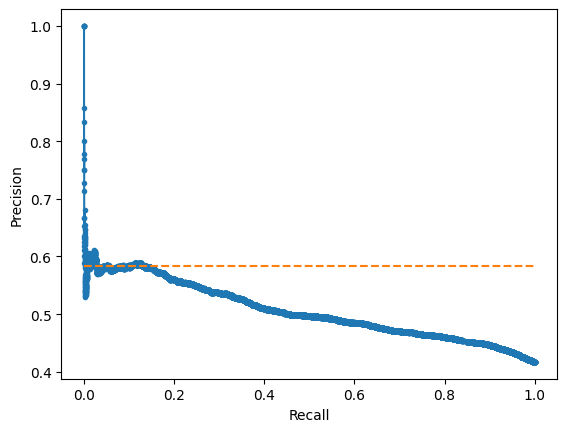

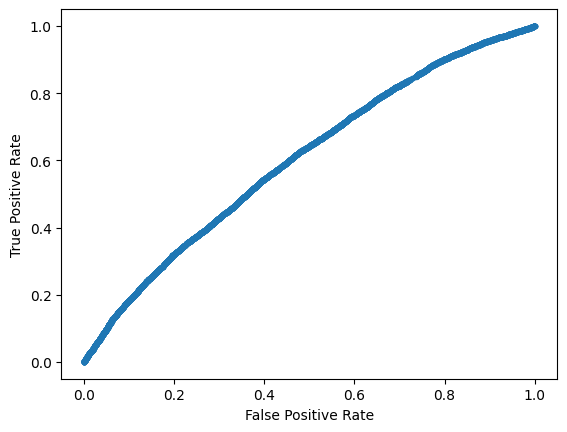

Accuracy: 58.17% Precision: 49.85% Recall: 47.09%
F1: 48.43% MCC: 0.1331
AUPRC: 50.56% AUROC: 60.36%
 accuracy [58.17243356910724]
 precision [49.85442546583851]
 recall [47.0852428964253]
 F1 [48.43028188931838]
 MCC [0.13312537584697398]
 AUPRC [50.563680093503784]
 AUROC [60.36488289800054]

Training # 2 4
2023-04-13 19:30:51.843545
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.4.validation_genes.txt
2023-04-13 19:30:53.798668
Discriminator ZERO 0
Train 1:0 42241:62452 40.35%
Computed class weights: {0: 0.8381877281752386, 1: 1.2392343931251628}
Valid 1:0 10999:15519 41.48%
FIT
2023-04-13 19:30:55.097636


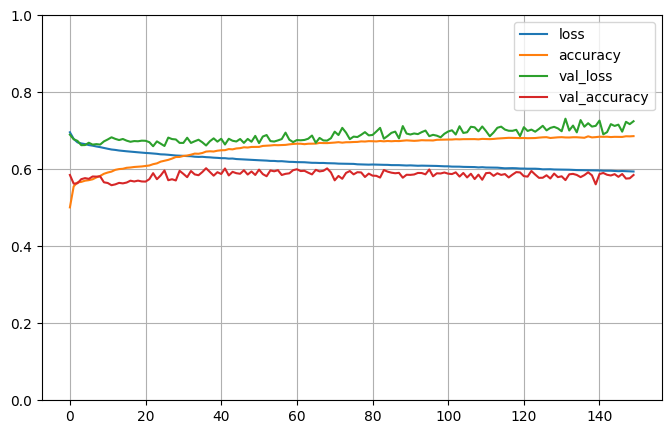


Testing # 2 4
2023-04-13 20:24:21.059680
2023-04-13 20:24:21.059768
PREDICT
2023-04-13 20:24:21.342250
Test 1:0 10999:15519 41.48%
Predict 1:0 10201:16317 38.47%
Test sizes (26518, 1025) (26518,)
Distrib of scores: 0.4679456 mean 0.22155479 std
Range of scores: 0.003318773 to 0.9696451
Score threshold 0.5
Confusion matrix
 [[10418  5101]
 [ 5899  5100]]
Normalized matrix
 [[0.39286522 0.19235991]
 [0.22245267 0.1923222 ]]
Extreme scores correct, pos:neg 3195 4416
Extreme scores incorrect pos:neg 2823 1644


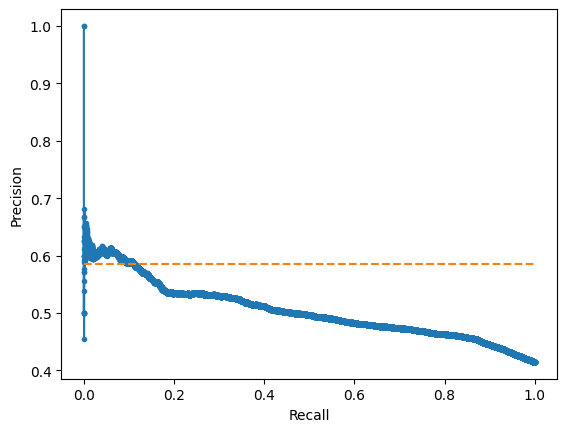

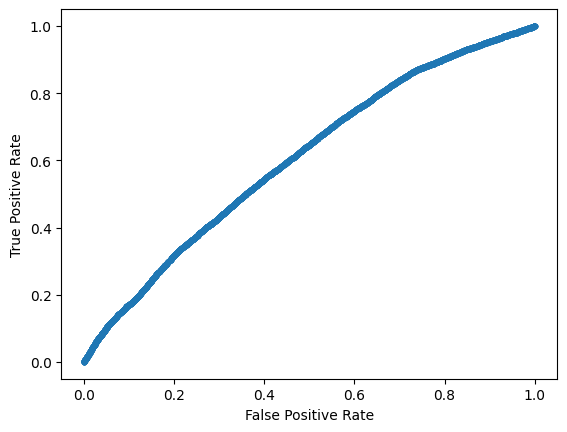

Accuracy: 58.52% Precision: 50.00% Recall: 46.37%
F1: 48.11% MCC: 0.1367
AUPRC: 50.42% AUROC: 60.63%
 accuracy [58.51874198657515]
 precision [49.995098519752965]
 recall [46.36785162287481]
 F1 [48.113207547169814]
 MCC [0.13669459564223468]
 AUPRC [50.42101723036291]
 AUROC [60.626400547774885]

Training # 2 5
2023-04-13 20:24:25.264992
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/pc.2.5.validation_genes.txt
2023-04-13 20:24:26.461245
Discriminator ZERO 0
Train 1:0 43013:62045 40.94%
Computed class weights: {0: 0.8466274478201306, 1: 1.2212354404482366}
Valid 1:0 10227:15926 39.10%
FIT
2023-04-13 20:24:28.013727


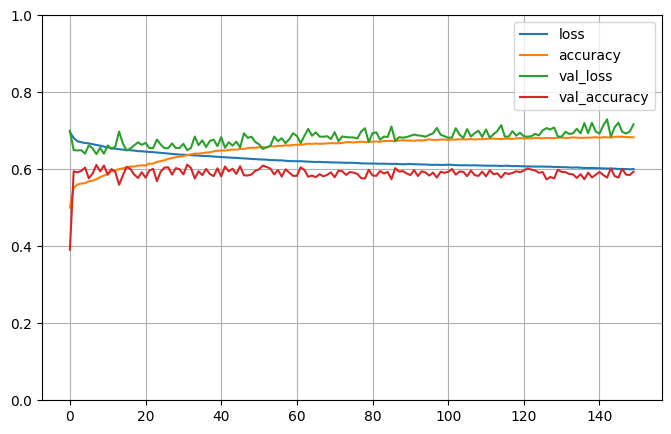


Testing # 2 5
2023-04-13 21:18:52.644334
2023-04-13 21:18:52.644400
PREDICT
2023-04-13 21:18:53.126444
Test 1:0 10227:15926 39.10%
Predict 1:0 9804:16349 37.49%
Test sizes (26153, 1025) (26153,)
Distrib of scores: 0.47732753 mean 0.22241852 std
Range of scores: 0.021099709 to 0.9887227
Score threshold 0.5
Confusion matrix
 [[10826  5100]
 [ 5523  4704]]
Normalized matrix
 [[0.41394869 0.19500631]
 [0.21118036 0.17986464]]
Extreme scores correct, pos:neg 3395 4508
Extreme scores incorrect pos:neg 3385 1206


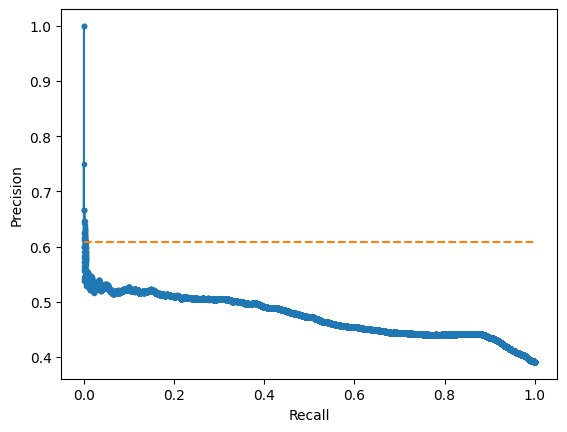

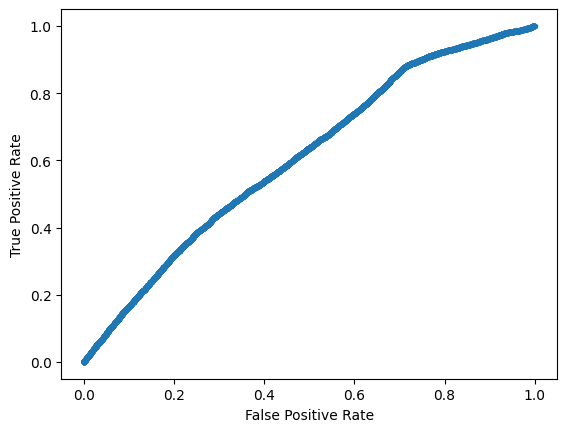

Accuracy: 59.38% Precision: 47.98% Recall: 46.00%
F1: 46.97% MCC: 0.1409
AUPRC: 47.40% AUROC: 60.90%
 accuracy [59.381332925477004]
 precision [47.98041615667075]
 recall [45.9958932238193]
 F1 [46.967200838700016]
 MCC [0.1408520765775755]
 AUPRC [47.40096143543927]
 AUROC [60.89522271168081]
2023-04-13 21:18:56.786530


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 58.11% std 0.94
 precision mean 48.49% std 1.49
 recall mean 49.81% std 4.80
 F1 mean 49.00% std 2.12
 MCC mean 0.1357 std 0.0085
 AUPRC mean 49.37% std 1.42
 AUROC mean 60.35% std 0.50
 accuracy [[58.5194283162126], [57.02101736216875], [58.065658951346244], [59.16814023218267], [56.20569370991335], [58.15619223659889], [57.89075216716508], [58.17243356910724], [58.51874198657515], [59.381332925477004]]
 precision [[47.20763723150358], [49.03431626142438], [48.7192493025615], [49.65134016125518], [46.416938110749186], [49.97805670148337], [46.080612154106234], [49.85442546583851], [49.995098519752965], [47.98041615667075]]
 recall [[46.827651515151516], [51.400939985538685], [55.68115942028985], [43.16158363326388], [58.554351886440045], [52.42611177607955], [50.561358976862245], [47.0852428964253], [46.36785162287481], [45.9958932238193]]
 F1 [[47.01687663418112], [50.18974494748918], [51.96807791153793], [46.179570328334016], [51.783944499504464], [51.17282286330548],